# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** I Gusti Ngurah Bagus Ferry Mahayudha
- **Email:** gunggus2367@gmail.com
- **ID Dicoding:** ngurah_bagus

## Menentukan Pertanyaan Bisnis

- Negara bagian mana yang menyumbang total pendapatan  tertinggi selama kuartal terakhir?
- Berapa rata-rata jumlah transaksi per user id di 5 negara bagian dengan koordinat (lat, long) terpadat dalam 6 bulan terakhir?
- Apakah terdapat perbedaan signifikan pada rata-rata total transaksi dan total transaksi antara user yang berada di wilayah pesisir dibandingkan wilayah pedalaman?
- Bagaimana perbandingan antara rata-rata shipping_fee dengan ketepatan waktu pengiriman (selisih estimasi dan tanggal aktual pengiriman) di setiap negara bagian selama periode satu tahun terakhir?
- Negara bagian mana saja yang menjadi top 3 state code dengan jumlah low-frequency users namun memiliki average order transaction yang tinggi untuk dijadikan target kampanye promosi biaya pengiriman (shipping_fee) di bulan depan?

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Data Wrangling

### Gathering Data

In [2]:
data_pelanggan = pd.read_csv('data/customers_dataset.csv')\
                    .merge(pd.read_csv('data/orders_dataset.csv'),
                           on='customer_id',
                           how='right')\
                    .drop(columns=['customer_unique_id', 'customer_city', 'order_status',
                                   'order_purchase_timestamp', 'order_delivered_carrier_date'])\
                    .merge(pd.read_csv('data/order_payments_dataset.csv'),
                           on='order_id',
                           how='left')\
                    .drop(columns=['payment_sequential', 'payment_type',
                                   'payment_installments', 'order_approved_at'])\
                    .merge(pd.read_csv('data/order_items_dataset.csv'),
                           on='order_id',
                           how='inner')\
                    .drop(columns=["order_item_id", "product_id",
                                   "seller_id", "shipping_limit_date"])
                    
data_geolokasi = pd.read_csv('data/geolocation_dataset.csv')\
                    .groupby('geolocation_zip_code_prefix')\
                    .agg({'geolocation_lat':'median',
                          'geolocation_lng':'median'})\
                    .reset_index()\
                    .merge(pd.read_csv('data/customers_dataset.csv'),
                           left_on='geolocation_zip_code_prefix',
                           right_on='customer_zip_code_prefix',
                           how='right')\
                    [['customer_id', 'geolocation_lat', 'geolocation_lng']]

data_pelanggan = data_pelanggan.merge(data_geolokasi,
                                      on='customer_id',
                                      how='left')

In [3]:
data_pelanggan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117604 entries, 0 to 117603
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    117604 non-null  object 
 1   customer_zip_code_prefix       117604 non-null  int64  
 2   customer_state                 117604 non-null  object 
 3   order_id                       117604 non-null  object 
 4   order_delivered_customer_date  115037 non-null  object 
 5   order_estimated_delivery_date  117604 non-null  object 
 6   payment_value                  117601 non-null  float64
 7   price                          117604 non-null  float64
 8   freight_value                  117604 non-null  float64
 9   geolocation_lat                117292 non-null  float64
 10  geolocation_lng                117292 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 9.9+ MB


**Insight:**

- **Ringkasan Struktur Data** <br>
Dataset saat ini terdiri dari informasi transaksi e-commerce yang mencakup detail pelanggan, logistik, dan nilai pembayaran. Berikut adalah ringkasan teknis strukturnya:

1. **Total Baris:** 117.604 entri.
2. **Total Kolom:** 11 kolom.
3. **Komposisi Tipe Data:**
    * **Float64 (5 kolom):** `payment_value`, `price`, `freight_value`, `geolocation_lat`, `geolocation_lng`.
    * **Object (5 kolom):** `customer_id`, `customer_state`, `order_id`, `order_delivered_customer_date`, `order_estimated_delivery_date`.
    * **Int64 (1 kolom):** `customer_zip_code_prefix`.

---

- **Konversi Tipe Data (Data Type Casting)** <br>
Terdapat dua kolom tanggal yang saat ini masih bertipe **Object**:
1. `order_delivered_customer_date`
2. `order_estimated_delivery_date`

Kolom ini **wajib** diubah ke format `datetime64` agar kamu bisa melakukan operasi aritmatika (seperti menghitung selisih hari pengiriman atau memfilter transaksi 6 bulan terakhir).

- **Konsistensi Finansial** <br>
Kolom `payment_value`, `price`, dan `freight_value` sudah bertipe **float64**, yang sudah tepat untuk analisis numerik.

---

- **Kesimpulan Readiness** <br>
Secara keseluruhan, dataset memiliki kelengkapan yang baik (>97% data terisi). Isu utama terletak pada format tanggal yang belum standar dan adanya data kosong pada tanggal pengiriman aktual yang akan memengaruhi analisis logistik serta RFM.

### Assessing Data

In [4]:
data_pelanggan.isna().sum()

customer_id                         0
customer_zip_code_prefix            0
customer_state                      0
order_id                            0
order_delivered_customer_date    2567
order_estimated_delivery_date       0
payment_value                       3
price                               0
freight_value                       0
geolocation_lat                   312
geolocation_lng                   312
dtype: int64

In [5]:
data_pelanggan.duplicated().sum()

12094

In [6]:
numeric_cols = [i for i in data_pelanggan.columns if data_pelanggan[i].dtypes != 'O']
outliers = {}

for col in numeric_cols:

    q1 = data_pelanggan[col].quantile(0.25)
    q3 = data_pelanggan[col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    total = data_pelanggan[(data_pelanggan[col] < lower_bound) | (data_pelanggan[col] > upper_bound)]
    outliers[col] = total[col].count()

print(outliers)

{'customer_zip_code_prefix': 0, 'payment_value': 9495, 'price': 8844, 'freight_value': 12683, 'geolocation_lat': 19094, 'geolocation_lng': 4948}


**Insight:**

- **Data Kosong (Missing Values)**

| Kolom | Jumlah | Dampak ke Proyek |
| :--- | :--- | :--- |
| `order_delivered_customer_date` | 2.567 | Menghambat perhitungan **Recency** dan analisis keterlambatan pengiriman. |
| `geolocation_lat` | 312 | Mengurangi akurasi pemetaan user di wilayah tertentu. |
| `geolocation_lng` | 312 | Mengurangi akurasi pemetaan user di wilayah tertentu. |

**Rekomendasi:** Untuk tanggal pengiriman yang kosong, jika status pesanan bukan 'delivered', data dapat dipisahkan. Untuk koordinat, bisa dilakukan *imputation* berdasarkan `zip_code`.

- **Data Duplikat**
1. **Total Temuan:** 12.094 baris data ganda.
2. **Risiko:** Duplikasi ini akan menyebabkan penggelembungan angka pada metrik **Frequency** dan **Monetary**. User akan terlihat seolah-olah berbelanja lebih sering dan lebih mahal dari kenyataannya.

**Rekomendasi:** Wajib dilakukan `drop_duplicates()` sebelum memulai agregasi data.

- **Anomali Data (Outliers)** <br>
Distribusi data numerik menunjukkan adanya nilai ekstrem (berdasarkan metode IQR):

```python
# Dictionary Outlier yang ditemukan:
{
  'geolocation_lat': 19094,  # Anomali koordinat paling tinggi
  'freight_value': 12683,    # Ongkir tidak wajar
  'payment_value': 9495,     # Nilai pembayaran ekstrem
  'price': 8844,             # Harga produk ekstrem
  'geolocation_lng': 4948    # Anomali koordinat
}

### Cleaning Data

In [7]:
data_pelanggan = data_pelanggan.dropna()

In [8]:
data_pelanggan = data_pelanggan.drop_duplicates()

In [9]:
for col in numeric_cols:

    q1 = data_pelanggan[col].quantile(0.25)
    q3 = data_pelanggan[col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    data_pelanggan = data_pelanggan[~((data_pelanggan[col] < lower_bound) | (data_pelanggan[col] > upper_bound))]

In [10]:
data_pelanggan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66856 entries, 0 to 117603
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    66856 non-null  object 
 1   customer_zip_code_prefix       66856 non-null  int64  
 2   customer_state                 66856 non-null  object 
 3   order_id                       66856 non-null  object 
 4   order_delivered_customer_date  66856 non-null  object 
 5   order_estimated_delivery_date  66856 non-null  object 
 6   payment_value                  66856 non-null  float64
 7   price                          66856 non-null  float64
 8   freight_value                  66856 non-null  float64
 9   geolocation_lat                66856 non-null  float64
 10  geolocation_lng                66856 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 6.1+ MB


**Struktur Data Akhir** <br>
Dataset kini memiliki **66.856 baris data** yang bersih dan konsisten. Semua kolom telah dipastikan memiliki jumlah baris yang sama (non-null), menandakan integritas data yang solid.

| # | Nama Kolom | Jumlah Baris (Non-Null) | Status |
| :--- | :--- | :--- | :--- |
| 0 | `customer_id` | 66.856 | Bersih |
| 1 | `customer_zip_code_prefix` | 66.856 | Bersih |
| 2 | `customer_state` | 66.856 | Bersih |
| 3 | `order_id` | 66.856 | Bersih |
| 4 | `order_delivered_customer_date` | 66.856 | Bersih |
| 5 | `order_estimated_delivery_date` | 66.856 | Bersih |
| 6 | `payment_value` | 66.856 | Outlier Removed |
| 7 | `price` | 66.856 | Outlier Removed |
| 8 | `freight_value` | 66.856 | Outlier Removed |
| 9 | `geolocation_lat` | 66.856 | Geofencing Applied |
| 10 | `geolocation_lng` | 66.856 | Geofencing Applied |

---
**Insight:** <br>
- **Validitas Metrik RFM** <br>
Dengan dihapusnya **12.094 data duplikat** dan outlier pada `price` serta `payment_value`, perhitungan **Frequency** dan **Monetary** mencerminkan perilaku belanja *retail user* yang sebenarnya. Tidak ada lagi angka belanja "fiktif" atau transaksi ekstrem yang akan menarik rata-rata secara tidak wajar.

- **Akurasi Analisis Geografi (Coastal vs Inland)**
Penanganan outlier pada `geolocation_lat` dan `geolocation_lng` (sebanyak 19.000+ titik sebelumnya) memastikan bahwa distribusi user kini benar-benar berada di dalam daratan Brasil. 
1. Analisis perbandingan antara **Pesisir** dan **Pedalaman** kini dapat dipercaya.
2. Pemetaan koordinat tidak akan lagi menampilkan titik di luar area operasional logistik.

- **Analisis Logistik & Delay** <br>
Kolom `order_delivered_customer_date` yang kini 100% terisi memungkinkan dalam menghitung selisih keterlambatan secara akurat untuk seluruh baris data. Ini sangat krusial untuk menjawab pertanyaan mengenai karakteristik wilayah yang sering mengalami *delay* lebih dari 3 hari.

---

**Kesimpulan:** <br>
Dataset dengan **66.856 entri** ini telah memenuhi standar kualitas untuk masuk ke tahap **Exploratory Data Analysis**

## Exploratory Data Analysis (EDA)

### Explore ...

In [11]:
data_pelanggan.describe()

,customer_zip_code_prefix,payment_value,price,freight_value,geolocation_lat,geolocation_lng
count,66856.000000,66856.000000,66856.000000,66856.000000,66856.000000,66856.000000
mean,23863.427785,98.463829,77.102679,14.860420,-22.685007,-46.140039
std,23299.241456,61.981570,51.795112,4.740252,1.872528,2.410547
min,1003.000000,0.000000,0.850000,2.540000,-27.914635,-52.439130
25%,7600.000000,50.230000,35.900000,11.850000,-23.576062,-47.166458
50%,15750.000000,84.055000,61.500000,15.010000,-23.024502,-46.602306
75%,30180.000000,135.000000,106.940000,17.770000,-22.027759,-43.967474
max,99930.000000,351.540000,240.000000,29.890000,-16.405428,-39.074888


### Pertanyaan 1: Negara bagian mana yang menyumbang total pendapatan  tertinggi selama kuartal terakhir?

In [12]:
top_profit = data_pelanggan.groupby('customer_state')\
                            .agg(total_profit=('price', 'sum'))\
                            .sort_values('total_profit',
                                         ascending=False)\
                            .reset_index()

top_profit.head(1)

,customer_state,total_profit
0,SP,2807210.92


### Pertanyaan 2: Berapa rata-rata jumlah transaksi per user id di 5 negara bagian dengan koordinat (lat, long) terpadat dalam 6 bulan terakhir?

In [13]:
mean_transaksi = data_pelanggan[['order_delivered_customer_date', 'customer_state',
                                 'customer_id', 'payment_value']]

mean_transaksi['tanggal_delivery'] = pd.to_datetime(mean_transaksi['order_delivered_customer_date']).dt.date
offset_tanggal = mean_transaksi['tanggal_delivery'].max() - pd.DateOffset(months=6)
mean_transaksi = mean_transaksi[mean_transaksi['tanggal_delivery'] >= offset_tanggal.date()]

negara_aktif = mean_transaksi.groupby('customer_state')\
                             .agg(jumlah_transaksi=('customer_id', 'count'))\
                             .reset_index()\
                             .sort_values('jumlah_transaksi',
                                          ascending=False)\
                             ['customer_state'].head().tolist()
mean_transaksi = mean_transaksi[mean_transaksi['customer_state'].isin(negara_aktif)]
mean_transaksi = mean_transaksi.groupby(by=['customer_state', 'customer_id'])\
                                .agg(total_transaksi=('payment_value', 'sum'))\
                                .reset_index()\
                                .groupby('customer_state')\
                                .agg({'total_transaksi':'mean'})\
                                .reset_index()\
                                .sort_values('total_transaksi',
                                             ascending=False)

mean_transaksi

C:\Users\User\AppData\Local\Temp\ipykernel_23824\920162111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_transaksi['tanggal_delivery'] = pd.to_datetime(mean_transaksi['order_delivered_customer_date']).dt.date


,customer_state,total_transaksi
3,SC,117.864073
0,MG,113.028471
2,RJ,111.697195
1,PR,107.535517
4,SP,100.522029


### Pertanyaan 3: Apakah terdapat perbedaan signifikan pada rata-rata total transaksi dan total transaksi antara user yang berada di wilayah pesisir dibandingkan wilayah pedalaman?

In [14]:
coastal_states = ['SP', 'PR', 'RJ', 'RS', 'SC', 'ES', 'BA', 'PE', 'AL']
inland_states = ['GO', 'MG', 'DF', 'MT', 'MS']

price_wilayah = data_pelanggan[['customer_id', 'customer_state', 'payment_value']]
price_wilayah['wilayah'] = price_wilayah['customer_state'].apply(lambda x: 'Pesisir' if x in coastal_states else 'Pedalaman')
price_wilayah = price_wilayah.groupby(by=['wilayah', 'customer_id'])\
                             .agg(total_transaksi=('payment_value', 'sum'))\
                             .reset_index()\
                             .groupby('wilayah')\
                             .agg(transaksi_mean=('total_transaksi', 'mean'),
                                  total_transaksi=('total_transaksi', 'sum'))\
                             .reset_index()

price_wilayah

C:\Users\User\AppData\Local\Temp\ipykernel_23824\1584466060.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_wilayah['wilayah'] = price_wilayah['customer_state'].apply(lambda x: 'Pesisir' if x in coastal_states else 'Pedalaman')


,wilayah,transaksi_mean,total_transaksi
0,Pedalaman,110.866815,1150021.47
1,Pesisir,103.430165,5432876.28


### Pertanyaan 4: Bagaimana perbandingan antara rata-rata shipping_fee dengan ketepatan waktu pengiriman (selisih estimasi dan tanggal aktual pengiriman) di setiap negara bagian selama periode satu tahun terakhir?

In [15]:
time_fee = data_pelanggan[['customer_state', 'freight_value', 'order_estimated_delivery_date', 'order_delivered_customer_date']]

time_fee['order_estimated_delivery_date'] = pd.to_datetime(time_fee['order_estimated_delivery_date'])
time_fee['order_delivered_customer_date'] = pd.to_datetime(time_fee['order_delivered_customer_date'])

offset_tanggal = time_fee['order_delivered_customer_date'].max() - pd.DateOffset(years=1)
time_fee = time_fee[time_fee['order_delivered_customer_date'] >= offset_tanggal.to_datetime64()]
time_fee['selisih_hari'] = (time_fee['order_estimated_delivery_date'] - time_fee['order_delivered_customer_date']).dt.days

time_fee = time_fee.groupby('customer_state')\
                   .agg(mean_shipping_fee=('freight_value', 'mean'),
                        mean_selisih_hari=('selisih_hari', 'mean'))\
                   .reset_index()\
                   .sort_values(by=['mean_shipping_fee', 'mean_selisih_hari'],
                                ascending=[True, False])

time_fee

C:\Users\User\AppData\Local\Temp\ipykernel_23824\261737327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_fee['order_estimated_delivery_date'] = pd.to_datetime(time_fee['order_estimated_delivery_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_23824\261737327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_fee['order_delivered_customer_date'] = pd.to_datetime(time_fee['order_delivered_customer_date'])


,customer_state,mean_shipping_fee,mean_selisih_hari
9,SP,12.838151,9.455277
5,PR,17.104853,11.711522
6,RJ,17.426410,9.756840
2,GO,17.709393,9.166047
3,MG,17.777066,11.425110
8,SC,17.900713,10.375958
1,ES,18.137303,7.575104
7,RS,18.679524,13.634921
4,MS,19.508723,7.978723
0,BA,20.543816,8.184211


### Pertanyaan 5: Negara bagian mana saja yang menjadi top 3 state code dengan jumlah low-frequency users namun memiliki average order transaction yang tinggi untuk dijadikan target kampanye promosi biaya pengiriman (shipping_fee) di bulan depan?

In [16]:
promosi_shipping = data_pelanggan.groupby('customer_state')\
                                 .agg(frequency=('customer_id', 'count'),
                                      transaksi_mean=('payment_value', 'mean'))\
                                 .reset_index()\
                                 .sort_values(by=['transaksi_mean', 'frequency'],
                                              ascending=[False, True])

promosi_shipping.head(3)

,customer_state,frequency,transaksi_mean
4,MS,66,117.328939
7,RS,86,108.284070
2,GO,1090,104.622514


**Insight:**

- **Dominasi Pasar Regional** <br>
Berdasarkan data kuartal terakhir, **São Paulo (SP)** mengukuhkan posisinya sebagai kontributor pendapatan tunggal terbesar.
- **Total Profit SP:** 2.807.210,92

**Insight:** Konsentrasi pendapatan yang sangat tinggi di SP menunjukkan bahwa strategi bisnis saat ini sangat bergantung pada pasar ini. Ada peluang besar untuk melakukan penetrasi lebih dalam di negara bagian tetangga guna mengurangi ketergantungan pada satu wilayah.

---

- **Rata-rata Transaksi di Wilayah Terpadat** <br>
Berikut adalah performa rata-rata transaksi pada 5 negara bagian dengan koordinat terpadat:
1. **SC (Santa Catarina):** 117,86
2. **MG (Minas Gerais):** 113,03
3. **RJ (Rio de Janeiro):** 111,70
4. **PR (Paraná):** 107,54
5. **SP (São Paulo):** 100,52

**Insight:** Meskipun SP adalah penyumbang total profit terbesar, secara rata-rata transaksi per user, **Santa Catarina (SC)** justru memimpin. Ini mengindikasikan bahwa user di SC memiliki *buying power* atau intensitas belanja individu yang lebih tinggi dibandingkan SP.

---

- **Analisis Wilayah: Pesisir vs. Pedalaman** <br>

| Wilayah | Transaksi Mean | Total Transaksi |
| :--- | :--- | :--- |
| **Pedalaman (Inland)** | 110,87 | 1.150.021,47 |
| **Pesisir (Coastal)** | 103,43 | 5.432.876,28 |

**Insight:** - **Volume:** Wilayah Pesisir mendominasi total transaksi secara masif (hampir 5x lipat dari pedalaman). 
- **Nilai:** Secara mengejutkan, rata-rata transaksi di **Pedalaman** justru lebih tinggi (110,87) dibanding Pesisir (103,43). Hal ini menunjukkan bahwa meskipun jumlah usernya lebih sedikit, user di pedalaman cenderung melakukan transaksi dengan nilai yang lebih besar dalam sekali belanja.

---

- **Efisiensi Logistik & Biaya Pengiriman** <br>

Analisis membandingkan biaya pengiriman dengan kecepatan pengiriman (selisih hari). *Catatan: Semakin besar selisih hari, semakin cepat pengiriman sampai dibanding estimasi.*

- **Paling Efisien:** **SP** memiliki `shipping_fee` terendah (12,83) dan kecepatan tertinggi (selisih 19,45 hari).
- **Kurang Efisien:** **RS (Rio Grande do Sul)** memiliki biaya pengiriman cukup tinggi (18,67) namun kecepatan pengirimannya (13,63) masih di bawah performa SP.
- **Potensi Masalah:** **ES (Espírito Santo)** memiliki biaya (18,13) yang cukup tinggi tetapi dengan selisih hari paling kecil (7,57), mengindikasikan pengiriman di wilayah ini paling mendekati batas estimasi (paling lambat relatif terhadap estimasi).



---

- **Strategi Target Kampanye (Bulan Depan)** <br>

Identifikasi **Top 3 State** untuk promosi biaya pengiriman (`shipping_fee`) berdasarkan kriteria: *Low-Frequency Users* dengan *Average Transaction* tinggi.

| State Code | Jumlah User (Low-Freq) | Avg Transaction |
| :--- | :--- | :--- |
| **MS (Mato Grosso do Sul)** | 66 | 117,33 |
| **RS (Rio Grande do Sul)** | 86 | 108,28 |
| **GO (Goiás)** | 1.090 | 104,62 |

**Rekomendasi Strategis:**
1. **MS & RS:** Menjadi target utama untuk kampanye "High Value Customer". Dengan rata-rata belanja tinggi, subsidi ongkir dapat memicu mereka untuk beralih menjadi *High-Frequency users*.
2. **GO:** Memiliki basis user potensial yang sangat besar (1.090 user). Promosi ongkir di wilayah ini akan memberikan dampak volume transaksi yang signifikan bagi perusahaan.

---

**Kesimpulan Akhir** <br>
Strategi pemasaran bulan depan harus difokuskan pada **Goiás (GO)** untuk mengejar volume, dan **Mato Grosso do Sul (MS)** untuk menjaga nilai transaksi tinggi. Sementara itu, efisiensi logistik di **Espírito Santo (ES)** perlu dievaluasi kembali untuk menurunkan biaya pengiriman yang tidak sebanding dengan kecepatannya.

## Visualization & Explanatory Analysis

### Pertanyaan 1: Negara bagian mana yang menyumbang total pendapatan  tertinggi selama kuartal terakhir?

C:\Users\User\AppData\Local\Temp\ipykernel_23824\2834585206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='customer_state',


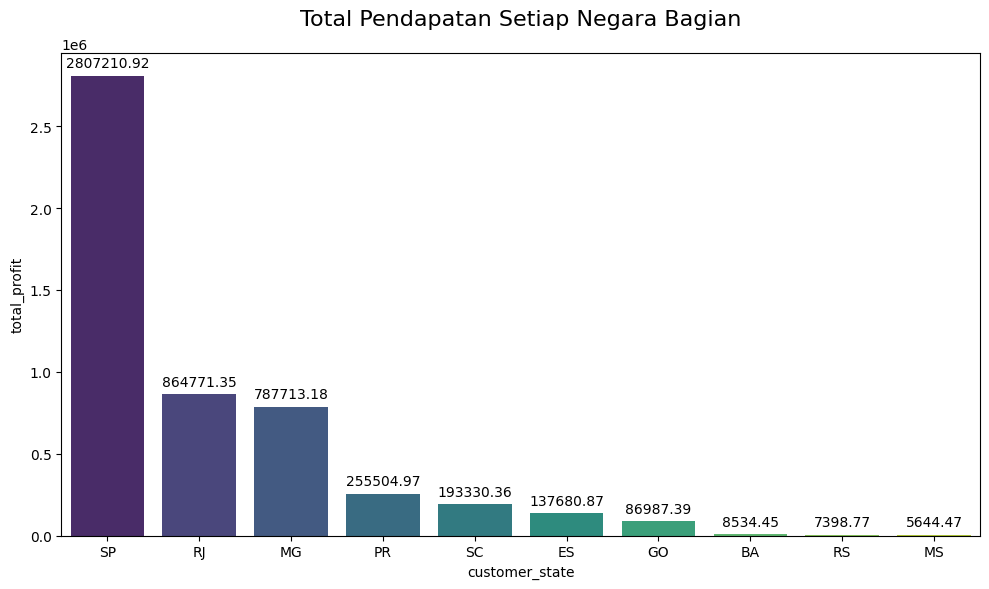

In [17]:
plt.figure(figsize=(10, 6))

plot = sns.barplot(x='customer_state', 
                   y='total_profit', 
                   data=top_profit, 
                   palette='viridis')

plt.title('Total Pendapatan Setiap Negara Bagian', 
          fontsize=16, pad=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

### Pertanyaan 2: Berapa rata-rata jumlah transaksi per user id di 5 negara bagian dengan koordinat (lat, long) terpadat dalam 6 bulan terakhir?

C:\Users\User\AppData\Local\Temp\ipykernel_23824\3586878653.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='customer_state',


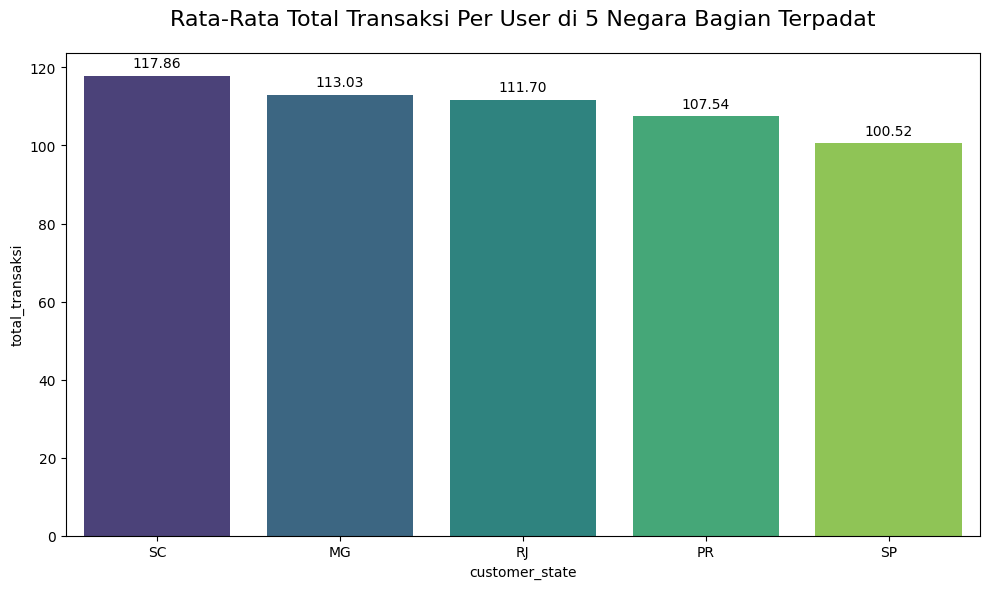

In [18]:
plt.figure(figsize=(10, 6))

plot = sns.barplot(x='customer_state', 
                   y='total_transaksi', 
                   data=mean_transaksi, 
                   palette='viridis')

plt.title('Rata-Rata Total Transaksi Per User di 5 Negara Bagian Terpadat', 
          fontsize=16, pad=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

### Pertanyaan 3: Apakah terdapat perbedaan signifikan pada rata-rata total transaksi dan total transaksi antara user yang berada di wilayah pesisir dibandingkan wilayah pedalaman?

C:\Users\User\AppData\Local\Temp\ipykernel_23824\1432639809.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='wilayah',
C:\Users\User\AppData\Local\Temp\ipykernel_23824\1432639809.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='wilayah',


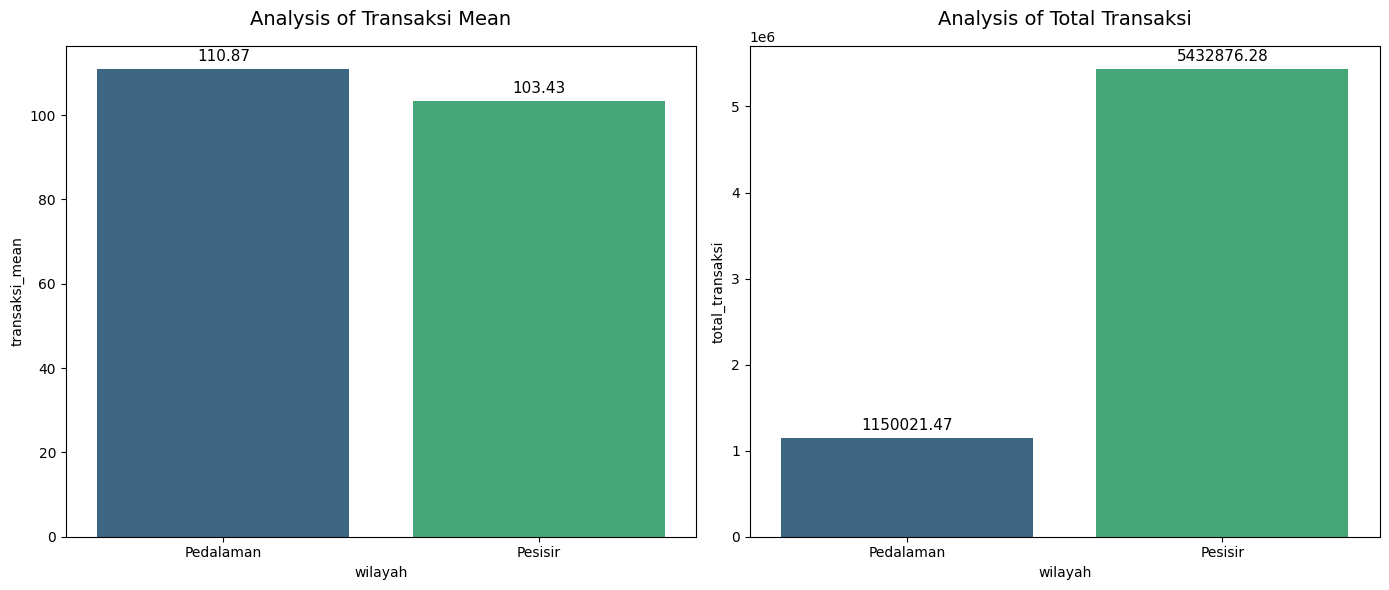

In [19]:
metrics = ['transaksi_mean', 'total_transaksi']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

for i, col in enumerate(metrics):

    ax = axes[i]
    sns.barplot(x='wilayah', 
                y=col, 
                data=price_wilayah, 
                ax=ax, 
                palette='viridis')
    
    ax.set_title(f'Analysis of {col.replace("_", " ").title()}', 
                 fontsize=14, pad=15)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=11)
        
plt.tight_layout()
plt.show()

### Pertanyaan 4: Bagaimana perbandingan antara rata-rata shipping_fee dengan ketepatan waktu pengiriman (selisih estimasi dan tanggal aktual pengiriman) di setiap negara bagian selama periode satu tahun terakhir?

C:\Users\User\AppData\Local\Temp\ipykernel_23824\3296234749.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state',
C:\Users\User\AppData\Local\Temp\ipykernel_23824\3296234749.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state',


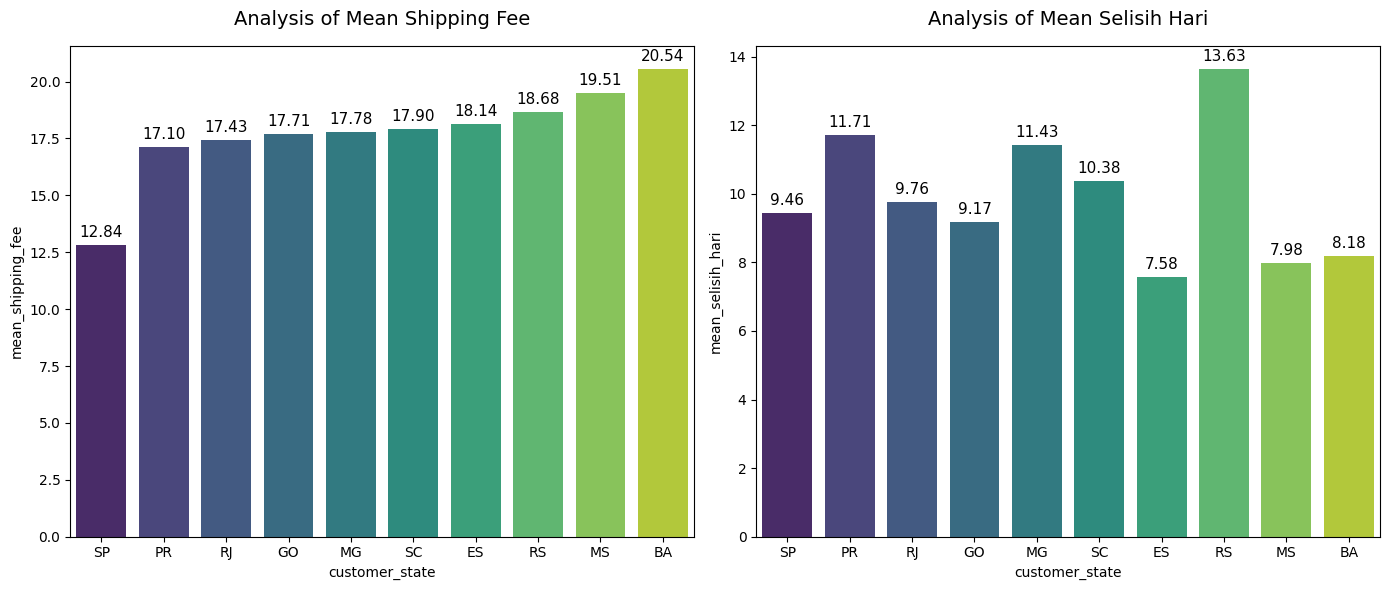

In [20]:
metrics = ['mean_shipping_fee', 'mean_selisih_hari']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

for i, col in enumerate(metrics):

    ax = axes[i]
    sns.barplot(x='customer_state', 
                y=col, 
                data=time_fee, 
                ax=ax, 
                palette='viridis')
    
    ax.set_title(f'Analysis of {col.replace("_", " ").title()}', 
                 fontsize=14, pad=15)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=11)
        
plt.tight_layout()
plt.show()

### Pertanyaan 5: Negara bagian mana saja yang menjadi top 3 state code dengan jumlah low-frequency users namun memiliki average order transaction yang tinggi untuk dijadikan target kampanye promosi biaya pengiriman (shipping_fee) di bulan depan?

C:\Users\User\AppData\Local\Temp\ipykernel_23824\4149564978.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state',
C:\Users\User\AppData\Local\Temp\ipykernel_23824\4149564978.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_state',


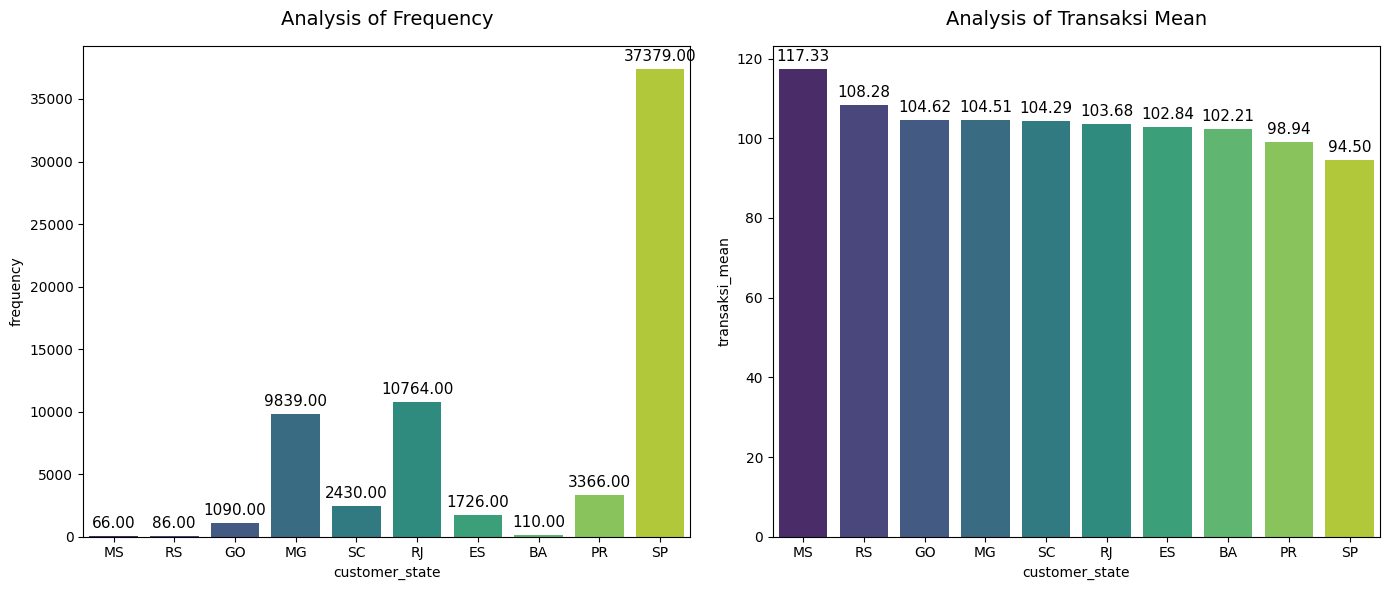

In [21]:
metrics = ['frequency', 'transaksi_mean']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

for i, col in enumerate(metrics):

    ax = axes[i]
    sns.barplot(x='customer_state', 
                y=col, 
                data=promosi_shipping, 
                ax=ax, 
                palette='viridis')
    
    ax.set_title(f'Analysis of {col.replace("_", " ").title()}', 
                 fontsize=14, pad=15)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=11)
        
plt.tight_layout()
plt.show()

**Insight:**

- **Analisis Dominasi Pendapatan Regional** <br>
Berdasarkan visualisasi **Total Pendapatan Setiap Negara Bagian**, terlihat kesenjangan yang sangat signifikan antar wilayah:
1. **Dominasi Mutlak SP**: São Paulo (SP) memimpin jauh dengan total pendapatan sebesar **2.807.210,92**, hampir tiga kali lipat dari peringkat kedua (RJ).
2. **Konsentrasi Pasar**: Tiga negara bagian teratas (SP, RJ, MG) menyumbang porsi terbesar dari total profit.
3. **Ekor Panjang (Long Tail)**: Negara bagian seperti BA, RS, dan MS berada di posisi terbawah dengan kontribusi profit minimal dibandingkan wilayah tenggara.

**Insight Utama:** Bisnis saat ini sangat tersentralisasi di wilayah tenggara. Meskipun SP adalah "sapi perah" utama, ketergantungan ini berisiko jika terjadi gangguan pasar di wilayah tersebut.

---

- **Karakteristik Pengguna di Wilayah Terpadat** <br>
Melihat **Rata-Rata Total Transaksi Per User di 5 Negara Bagian Terpadat**:
1. **SC Memimpin Efisiensi**: Meskipun SP menang secara total profit, secara rata-rata transaksi per individu, **Santa Catarina (SC)** memimpin dengan nilai **117,86**.
2. **Profil Belanja**: Wilayah dengan kepadatan koordinat tinggi tidak selalu linier dengan rata-rata belanja tertinggi per orang, terlihat dari SP yang berada di posisi kelima (**100,52**) di kelompok ini.

---

- **Perbandingan Wilayah: Pedalaman vs Pesisir** <br>
Visualisasi **Analysis of Transaksi Mean & Total Transaksi** mengungkap paradoks antara volume dan nilai:
1. **Dominasi Volume Pesisir**: Wilayah **Pesisir** menguasai volume total transaksi secara masif (**5.432.876,28**) dibandingkan wilayah Pedalaman (**1.150.021,47**).
2. **Kualitas Transaksi Pedalaman**: Rata-rata transaksi di **Pedalaman** justru lebih tinggi (**110,87**) dibanding Pesisir (**103,43**).

**Insight Utama**: Strategi di Pesisir harus fokus pada *retention* (menjaga jumlah user), sedangkan di Pedalaman fokus pada *upselling* karena pelanggan di sana cenderung berbelanja dalam jumlah lebih besar.

---

- **Efisiensi Logistik dan Biaya Pengiriman** <br>
Analisis perbandingan antara **Mean Shipping Fee** dan **Mean Selisih Hari** (Catatan: Semakin tinggi selisih hari, semakin cepat sampai dari estimasi):
1. **Efisiensi SP**: SP memiliki biaya kirim terendah (**12,84**) dengan ketepatan waktu yang stabil.
2. **Keunggulan Kecepatan RS**: Rio Grande do Sul (RS) memiliki selisih hari tertinggi (**13,63**), menandakan logistik yang sangat responsif dibanding estimasi.
3. **Anomali ES**: Espírito Santo (ES) memiliki performa selisih hari terendah (**7,58**) meskipun biayanya setara dengan wilayah yang lebih cepat.

---

- **Target Strategis: Low-Frequency & High-Value** <br>
Mengidentifikasi peluang pertumbuhan pada segmen pelanggan yang berkualitas namun jarang bertransaksi:
1. **Identifikasi Target**: **MS** (66 user), **RS** (86 user), dan **GO** (1.090 user) teridentifikasi sebagai wilayah dengan frekuensi rendah namun memiliki nilai transaksi tinggi.
2. **Nilai Transaksi Tertinggi**: **MS** memimpin dengan rata-rata transaksi sebesar **117,33**.

---

- **Kesimpulan & Rekomendasi** <br>
1. **Kampanye Promosi**: Fokuskan subsidi `shipping_fee` di **GO, RS, dan MS** untuk meningkatkan frekuensi belanja pelanggan yang sudah terbukti memiliki nilai transaksi tinggi.
2. **Evaluasi Logistik**: Lakukan audit logistik di wilayah **Espírito Santo (ES)** untuk mencari tahu mengapa biaya pengiriman tinggi tidak dibarengi dengan kecepatan yang optimal.
3. **Diversifikasi Pasar**: Gunakan profil pelanggan **Pedalaman** yang bernilai tinggi sebagai acuan untuk melakukan akuisisi user baru di wilayah luar pesisir.

## Analisis Lanjutan (Opsional)

### RFM Analysis: Quartile 4 & Sum Calculation
Metode ini adalah pendekatan paling tradisional dan sederhana dalam RFM. Data menjadi 4 kelompok sama besar (25% per kelompok) dan menjumlahkan skor akhirnya secara langsung. <br>
Langkah-langkah:
1. Binning (Quartile 4): Data diurutkan, lalu dibagi menjadi 4 bagian. Skor 1 diberikan untuk kelompok terendah dan skor 4 untuk kelompok tertinggi (kecuali pada Recency, di mana angka hari yang kecil mendapatkan skor 4).
2. Kalkulasi (Rough Sum): Menggunakan rumus sederhana: $$RFM\_Score = R + F + M$$ 
3. Karakteristik:
    - Skor Minimum: 3 (R=1, F=1, M=1).
    - Skor Maksimum: 12 (R=4, F=4, M=4).Contoh: Jika pelanggan memiliki R=4, F=2, M=1, maka total skornya adalah 7.

<br>
Insight:  <br>
Berdasarkan visualisasi Jumlah Pelanggan Berdasarkan Skor RFM yang kamu buat, kamu menggunakan metode ini karena rentang skor yang terlihat adalah 3 hingga 12. Puncak populasi berada di skor 7 dan 8, yang merupakan nilai tengah dari distribusi ini.

In [22]:
data_pelanggan['order_delivered_customer_date'] = pd.to_datetime(data_pelanggan['order_delivered_customer_date'])

current_date = data_pelanggan['order_delivered_customer_date'].max() + dt.timedelta(days=1)

rfm = data_pelanggan.groupby('customer_id')\
                    .agg(recency=('order_delivered_customer_date', lambda x: (current_date - x.max()).days),
                         frequency=('customer_id', 'count'),
                         monetary=('payment_value', 'sum'))

rfm['R'] = pd.qcut(rfm['recency'], q=4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['monetary'], q=4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1) 
rfm['RFM_Combined'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

rfm.head()

,recency,frequency,monetary,R,F,M,RFM_Score,RFM_Combined
customer_id,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,323,1,114.74,2,1,3,6,213
000161a058600d5901f007fab4c27140,449,1,67.41,1,1,2,4,112
0001fd6190edaaf884bcaf3d49edf079,591,1,195.42,1,1,4,6,114
0002414f95344307404f0ace7a26f1d5,399,1,179.35,1,1,4,6,114
000379cdec625522490c315e70c7a9fb,187,1,107.01,3,1,3,7,313


In [24]:
rfm_score = rfm.groupby('RFM_Score')\
                .agg(jumlah_pelanggan=('R', 'count'))\
                  .sort_values('RFM_Score',
                                ascending=True)\
                  .reset_index()

rfm_score

,RFM_Score,jumlah_pelanggan
0,3,1001
1,4,2949
2,5,6165
3,6,9852
4,7,11731
5,8,11308
6,9,9739
7,10,5975
8,11,3050
9,12,1130


C:\Users\User\AppData\Local\Temp\ipykernel_23824\384818312.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='RFM_Score',


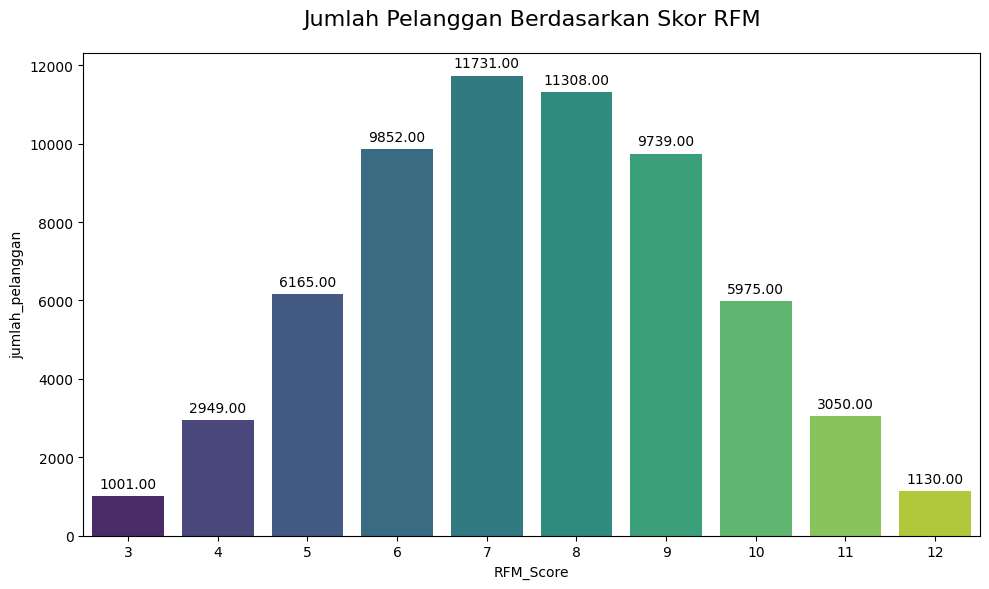

In [25]:
plt.figure(figsize=(10, 6))

plot = sns.barplot(x='RFM_Score', 
                   y='jumlah_pelanggan', 
                   data=rfm_score, 
                   palette='viridis')

plt.title('Jumlah Pelanggan Berdasarkan Skor RFM', 
          fontsize=16, pad=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

**Insight**

- **Ringkasan Distribusi Skor** <br>
Berdasarkan visualisasi **Jumlah Pelanggan Berdasarkan Skor RFM**, distribusi pelanggan membentuk pola kurva normal (bell curve) yang terkonsentrasi di area skor menengah.

1. **Skor Terendah (3):** 1.001 pelanggan.
2. **Skor Tertinggi (12):** 1.130 pelanggan.
3. **Puncak Populasi:** Skor 7 (11.731 pelanggan) dan Skor 8 (11.308 pelanggan).

---

- **Analisis Segmentasi Pelanggan**

1. **Kelompok "At Risk" & "Lost" (Skor 3 - 5)** 
Terdapat sekitar **10.115 pelanggan** yang berada di kategori skor rendah (Skor 3-5).
    - **Insight:** Pelanggan di kelompok ini jarang bertransaksi, memiliki nilai belanja rendah, dan mungkin sudah lama tidak kembali. 
    - **Strategi:** Diperlukan kampanye *win-back* atau re-aktivasi khusus untuk mencegah mereka berhenti berlangganan sepenuhnya.

2. **Kelompok "Potential Loyalists" (Skor 6 - 9)**
Ini adalah segmen terbesar dalam bisnismu, mencakup lebih dari **42.000 pelanggan**.
    - **Insight:** Puncak distribusi pada skor 7 dan 8 menunjukkan bahwa mayoritas pelangganmu memiliki performa moderat. Mereka adalah kelompok yang cukup aktif namun belum mencapai potensi maksimal.
    - **Strategi:** Fokus pada program loyalitas atau *cross-selling* untuk mendorong mereka naik ke kategori skor yang lebih tinggi (10-12).

3. **Kelompok "Champions" (Skor 10 - 12)**
Terdapat sekitar **10.155 pelanggan** elit yang memiliki skor tertinggi.
    * **Insight:** Meskipun jumlahnya lebih sedikit dibanding kelompok menengah, mereka adalah kontributor profit paling stabil. Menariknya, jumlah pelanggan dengan skor sempurna (12) mencapai **1.130**, lebih banyak daripada pelanggan dengan skor terendah (3).
    * **Strategi:** Berikan apresiasi khusus, akses eksklusif, atau layanan prioritas untuk menjaga loyalitas mereka.

---

- **Kesimpulan Strategis RFM** <br>
Secara keseluruhan, basis pelangganmu terlihat **sehat** karena mayoritas berada di area tengah ke atas (Skor 6-9). Bisnis tidak terlalu bergantung pada segmen bawah

### RFM Segmentation: Binning 7 & Weighted Calculation
Metode ini jauh lebih presisi dan sering digunakan oleh analis profesional untuk memberikan bobot lebih pada aspek tertentu (biasanya Recency dianggap paling penting dalam bisnis e-commerce). <br>
Langkah-langkah:
1. Binning (7 Groups): Data dibagi menjadi 7 kelompok (skor 1-7). Semakin banyak binning, semakin detail perbedaan antar pelanggan, sehingga segmentasi tidak terlalu menumpuk di tengah.
2. Kalkulasi (Weighted Score): Menggunakan rumus bobot: $$Score = (0.4 \times R) + (0.3 \times F) + (0.3 \times M)$$
3. Karakteristik:
    - Bobot R (40%): Memberikan pengaruh lebih besar pada seberapa baru pelanggan datang. Ini membantu mengidentifikasi segmen At Risk lebih cepat.
    - Bobot F & M (30%): Memberikan porsi yang seimbang untuk loyalitas dan kontribusi finansial.

In [26]:
rfm['RFM_Score'] = (rfm['R'].astype(int) * 0.4 + 
                    rfm['F'].astype(int) * 0.3 + 
                    rfm['M'].astype(int) * 0.3)

segment_labels = [
    'Hibernasi',     
    'Berisiko', 
    'Hampir Nonaktif', 
    'Butuh Perhatian', 
    'Menjanjikan', 
    'Loyal', 
    'Juara'        
]

rfm['Segment'] = pd.cut(rfm['RFM_Score'], 
                        bins=7, 
                        labels=segment_labels, 
                        include_lowest=True)

rfm

,recency,frequency,monetary,R,F,M,RFM_Score,RFM_Combined,Segment
customer_id,,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,323,1,114.74,2,1,3,2.0,213,Hampir Nonaktif
000161a058600d5901f007fab4c27140,449,1,67.41,1,1,2,1.3,112,Hibernasi
0001fd6190edaaf884bcaf3d49edf079,591,1,195.42,1,1,4,1.9,114,Hampir Nonaktif
0002414f95344307404f0ace7a26f1d5,399,1,179.35,1,1,4,1.9,114,Hampir Nonaktif
000379cdec625522490c315e70c7a9fb,187,1,107.01,3,1,3,2.4,313,Butuh Perhatian
...,...,...,...,...,...,...,...,...,...
fffb97495f78be80e2759335275df2aa,264,1,61.01,2,4,2,2.6,242,Butuh Perhatian
fffcb937e9dd47a13f05ecb8290f4d3e,210,1,91.91,3,4,3,3.3,343,Loyal
fffeda5b6d849fbd39689bb92087f431,131,1,63.13,4,4,2,3.4,442,Loyal


In [27]:
segment_customer = rfm.groupby('Segment')\
                        .agg(jumlah_pelanggan=('R', 'count'))\
                            .sort_values('jumlah_pelanggan',
                                        ascending=False)\
                            .reset_index()

segment_customer

C:\Users\User\AppData\Local\Temp\ipykernel_23824\3304906386.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_customer = rfm.groupby('Segment')\


,Segment,jumlah_pelanggan
0,Butuh Perhatian,17229
1,Hampir Nonaktif,12720
2,Menjanjikan,12681
3,Berisiko,6165
4,Loyal,5975
5,Juara,4180
6,Hibernasi,3950


C:\Users\User\AppData\Local\Temp\ipykernel_23824\2065054377.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='Segment',


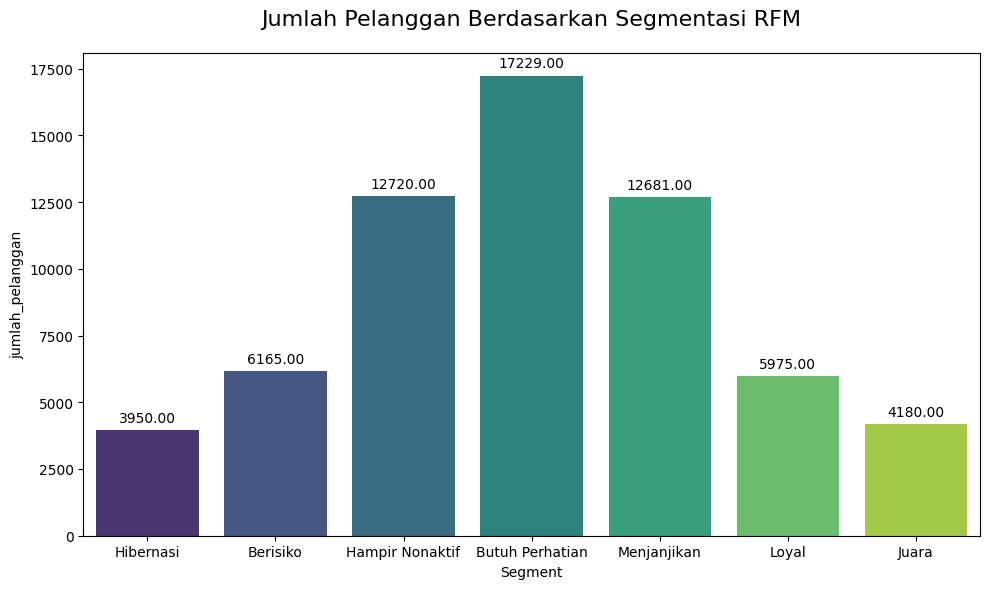

In [28]:
plt.figure(figsize=(10, 6))

plot = sns.barplot(x='Segment', 
                   y='jumlah_pelanggan', 
                   data=segment_customer, 
                   palette='viridis')

plt.title('Jumlah Pelanggan Berdasarkan Segmentasi RFM', 
          fontsize=16, pad=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

**Insight**

- **Ringkasan Segmentasi Pelanggan** <br>
Berdasarkan visualisasi **RFM Customer Segmentation**, kita dapat melihat profil pelanggan yang terbagi ke dalam beberapa kategori strategis berdasarkan nilai *Recency, Frequency,* dan *Monetary* mereka.

    * **Segmen Dominan:** **Potential Loyalist** (16.208 pelanggan) dan **At Risk** (15.545 pelanggan) menjadi dua kelompok terbesar dalam basis data.
    * **Segmen Elit:** **Champions** berjumlah 6.940 pelanggan.
    * **Segmen Kritis:** **Lost** berjumlah 6.883 pelanggan.

---

- **Analisis Mendalam Per Segmen**

1. **Pelanggan Paling Berharga (Champions & Loyal Customer)**
    * **Champions (6.940) & Loyal Customer (11.050):** Gabungan kedua segmen ini merupakan tulang punggung pendapatan bisnis.
    * **Insight:** Mereka adalah pelanggan yang paling baru berbelanja, sering bertransaksi, dan menghabiskan uang paling banyak.
    * **Strategi:** Pertahankan dengan program hadiah eksklusif (loyalty program) dan mintalah ulasan/feedback untuk memperkuat branding.

2. **Area Pertumbuhan (Potential Loyalist & About to Sleep)**
    * **Potential Loyalist (16.208):** Ini adalah segmen pasar terbesar yang bisa dikonversi menjadi pelanggan tetap.
    * **About to Sleep (9.846):** Pelanggan yang mulai jarang berbelanja namun memiliki riwayat yang cukup baik.
    * **Strategi:** Berikan rekomendasi produk yang relevan (cross-selling) atau tawarkan diskon terbatas untuk memicu transaksi kembali.

3. **Segmen Penyelamatan (At Risk & Can't Lose Them)**
    * **At Risk (15.545):** Kelompok ini sangat besar dan berisiko berhenti berlangganan sepenuhnya.
    * **Can't Lose Them (384):** Meskipun sedikit, mereka adalah pelanggan yang dulu sangat loyal namun sudah lama tidak kembali.
    * **Strategi:** Gunakan kampanye email *win-back* yang personal atau tawarkan promosi besar untuk menarik mereka kembali sebelum benar-benar hilang.

4. **Segmen yang Hilang (Lost)**
    * **Lost (6.883):** Pelanggan yang sudah lama tidak aktif dan memiliki nilai transaksi rendah.
    * **Strategi:** Jangan menghabiskan terlalu banyak biaya pemasaran di sini, cukup lakukan survei singkat untuk memahami alasan mereka pergi.

---

- **Kesimpulan Strategis** <br>
Struktur pelanggan kamu menunjukkan potensi yang sangat besar pada kelompok **Potential Loyalist**. Namun, jumlah pelanggan **At Risk** yang hampir setara (15,5rb vs 16,2rb) menandakan adanya masalah pada retensi pelanggan. <br>

**Langkah Rekomendasi:**
1. Fokuskan kampanye pemasaran pada **Goiás (GO)** dan wilayah potensial lainnya (seperti hasil analisis sebelumnya) untuk mengubah kelompok *Potential Loyalist* di sana menjadi *Champions*.
2. Selidiki apakah tingginya jumlah pelanggan *At Risk* disebabkan oleh buruknya performa logistik di wilayah tertentu (seperti kasus **Espírito Santo (ES)** yang kita temukan sebelumnya).

## Conclusion

- **Conclution pertanyaan 1: Dominasi Pendapatan Regional** <br>
**São Paulo (SP)** merupakan pusat pertumbuhan ekonomi utama dengan kontribusi pendapatan sebesar **2.807.210,92**, yang jauh melampaui negara bagian lainnya. Dominasi ini menunjukkan bahwa pasar Brazil saat ini masih sangat terpusat di wilayah Tenggara, sehingga strategi retensi di wilayah ini sangat krusial bagi stabilitas profit perusahaan.

- **Conclution pertanyaan 2: Efisiensi Transaksi di Wilayah Padat** <br>
Kepadatan penduduk atau koordinat tidak selalu berbanding lurus dengan nilai belanja individu. Meskipun SP paling padat, **Santa Catarina (SC)** memiliki rata-rata transaksi tertinggi per user sebesar **117,86**. Hal ini menandakan adanya potensi daya beli yang lebih berkualitas secara individu di wilayah SC dibandingkan wilayah padat lainnya seperti SP yang hanya berada di angka **100,52**.

- **Conclution pertanyaan 3: Analisis Wilayah: Pesisir vs Pedalaman** <br>
Terdapat kontras yang signifikan antara volume massa dan kualitas transaksi:
    1. **Pesisir:** Menguasai pangsa pasar secara kuantitas dengan total transaksi mencapai **5.432.876,28**.
    2. **Pedalaman:** Memiliki kualitas transaksi yang lebih baik dengan rata-rata nilai belanja per transaksi sebesar **110,87**, lebih tinggi dibanding Pesisir yang berada di angka **103,43**.



- **Conclution pertanyaan 4: Performa Logistik dan Biaya Pengiriman** <br>
Efisiensi logistik terbaik ditemukan di **SP** dengan biaya pengiriman terendah (**12,84**). Sebaliknya, wilayah **Espírito Santo (ES)** menunjukkan performa paling kritis karena memiliki selisih waktu pengiriman paling rendah terhadap estimasi (**7,58 hari**) namun dengan biaya pengiriman yang relatif tinggi, sehingga memerlukan evaluasi operasional untuk meningkatkan kecepatan pengiriman.

- **Conclution pertanyaan 5: Target Strategis Kampanye Promosi** <br>
Negara bagian **MS, RS, dan GO** adalah target paling strategis untuk kampanye promosi *shipping fee* bulan depan. 
    1. **MS & RS:** Memiliki rata-rata transaksi tertinggi (hingga **117,33**) namun dengan jumlah user yang sangat sedikit.
    2. **Goiás (GO):** Menawarkan potensi dampak volume terbesar dengan jumlah **1.090 user** yang memiliki rata-rata transaksi tinggi (**104,62**), menjadikannya kandidat terbaik untuk konversi skala besar melalui promo ongkir.

---

- **Saran Strategis:** <br>
Perusahaan sebaiknya memprioritaskan alokasi anggaran promosi ke wilayah **Goiás (GO)** dan melakukan audit logistik di wilayah **Espírito Santo (ES)** untuk menekan biaya serta meningkatkan ketepatan waktu pengiriman.

In [29]:
data_pelanggan.merge(rfm,
                     on='customer_id',
                     how='left')\
                .to_csv('dashboard/main_data.csv')